# ESP normal operation

---Training AI to learn normal pattern---
 Learned Health Threshold:           -0.0213
   - (Noise):                        -0.1675
   - Worst 24h trend (Real):          0.0087
 NEW DEFINED CUTOFF THRESHOLD:       -0.0213
 System calibrated and saved. Ready to detect real failures.


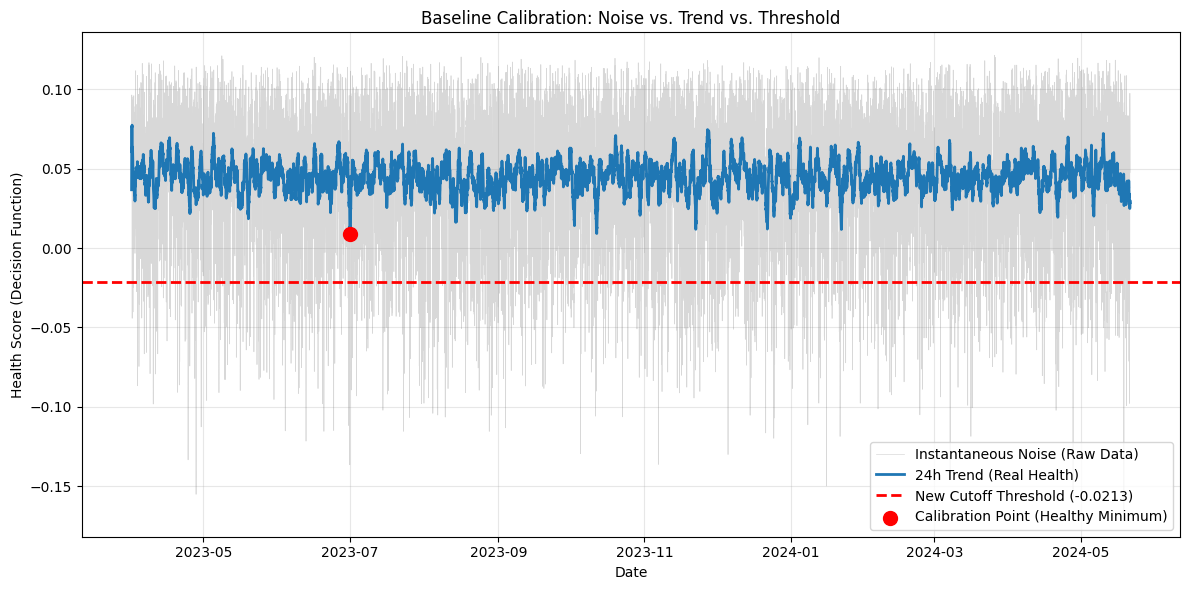

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import joblib
import matplotlib.pyplot as plt

# 1.  Load data from file
df_esp = pd.read_csv('Data_esp.csv')
df_esp['Date'] = pd.to_datetime(df_esp['Date'])

df_esp['Desv_Voltaje'] = np.abs(480 - df_esp['Voltage_V'])
sensores_cols = ['Motor_Temp_C', 'Vibration_g', 'Desv_Voltaje', 'Amperage_A', 'PWF_psi']

X = df_esp[sensores_cols]

# 2.   TRAINING
print("---Training AI to learn normal pattern---")
iso_forest = IsolationForest(n_estimators=100,random_state=42)
iso_forest.fit(X)

# 3.   OBTAIN SCORES (Decision Function)
scores = iso_forest.decision_function(X)

# Convert to Pandas Series to enable the use of a rolling window
scores_series = pd.Series(scores, index=df_esp.index)
# Apply the SAME smoothing 
# This "flattens" the noise and gives us the real daily health trend
scores_smooth = scores_series.rolling(window=24, min_periods=1).mean()
df_esp["score"]=scores_smooth

# 4.   DEFINE THE THRESHOLD BASED ON THE TREND
# The limit is the worst DAILY AVERAGE the healthy pump had"
# This prevents a single noisy point from lowering the threshold artificially
umbral_corte = scores_smooth.min() - 0.03 
# Safety Margin: A safety margin of 0.03 was defined
# This guarantees a confidence level higher than 99.7% that a generated alert corresponds to a real anomaly and not to operational noise

print(f" Learned Health Threshold:           {umbral_corte:.4f}")
print(f"   - (Noise):                        {scores.min():.4f}")
print(f"   - Worst 24h trend (Real):          {scores_smooth.min():.4f}")
print(f" NEW DEFINED CUTOFF THRESHOLD:       {umbral_corte:.4f}")

# 5.   Saving the "Brain" (The trained model
joblib.dump(iso_forest, 'ESP_IA.joblib')

# Saving the "Measurement Rule" (The threshold and the columns)

configuracion = {
    'umbral_corte': umbral_corte,
    'columnas_entrenamiento': sensores_cols
}
joblib.dump(configuracion, 'configuracion_IA.pkl')

print(" System calibrated and saved. Ready to detect real failures.")

# 6.   VISUALIZACIÓN DE LA CALIBRACIÓN ---

plt.figure(figsize=(12, 6))
# A. Plot Instantaneous Noise (Gray and faint)
plt.plot(df_esp['Date'], scores, color='gray', alpha=0.3, linewidth=0.5, label='Instantaneous Noise (Raw Data)')

# B. Plot Smoothed Trend (Blue and solid)
plt.plot(df_esp['Date'], scores_smooth, color='#1f77b4', linewidth=2, label='24h Trend (Real Health)')

# C. Plot Calculated Threshold (Red Line)
plt.axhline(y=umbral_corte, color='red', linestyle='--', linewidth=2, label=f'New Cutoff Threshold ({umbral_corte:.4f})')

# D. Mark the "Worst Healthy Day" (Calibration Point)
peor_fecha = df_esp.iloc[scores_smooth.idxmin()]['Date']
plt.scatter(peor_fecha, scores_smooth.min(), color='red', s=100, zorder=5, label='Calibration Point (Healthy Minimum)')

# Graph
plt.title('Baseline Calibration: Noise vs. Trend vs. Threshold')
plt.ylabel('Health Score (Decision Function)')
plt.xlabel('Date')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [10]:
# SCIENTIFIC CALCULATION OF THE ALERT MARGIN 

# 1. First, we obtain the smoothed series from TRAINING

scores_series = pd.Series(scores, index=df_esp.index)
scores_smooth_train = scores_series.rolling(window=24, min_periods=1).mean()

# 2. Calculate statistics on the TREND 
media_sana = scores_smooth_train.mean()
desviacion_estandar = scores_smooth_train.std()

print("\n STATISTICAL ANALYSIS (On Smoothed Trend):")
print(f"   - Healthy Average:      {media_sana:.4f}")
print(f"   - Deviation (Sigma):    {desviacion_estandar:.4f}")

# Industry standards use Sigmas based on the actual variability of the trend to define limits
margen_sugerido_2sigma = 2 * desviacion_estandar
margen_sugerido_3sigma = 3 * desviacion_estandar

# A value greater than 2 Sigma has a 95% probability of being a real anomaly rather than just operational noise.
print(f"   - Suggested 2 Sigma :   {margen_sugerido_2sigma:.4f}")
print(f"   - Suggested 3 Sigma :   {margen_sugerido_3sigma:.4f}")


 STATISTICAL ANALYSIS (On Smoothed Trend):
   - Healthy Average:      0.0448
   - Deviation (Sigma):    0.0093
   - Suggested 2 Sigma :   0.0185
   - Suggested 3 Sigma :   0.0278
